# Special cases and non-periodontitis patient

In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
#%load_ext nb_black
# black formatter f|or jupyter lab
%load_ext lab_black

%run ../src/notebook_env.py


---------------------------------
Working on the host: Joachims-MacBook-Pro.local

---------------------------------
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

---------------------------------
Python interpreter: /opt/miniconda3/envs/idz-parostatus/bin/python

---------------------------------
Root (ROOT) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus
---------------------------------
data (DATA) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/data
---------------------------------
Attaching the following source folders:
/Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/src


**Import modules**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

## Load cohort dataset

In [3]:
fp = DATA.joinpath("processed")
fn = "dmsV_cohort.parquet"
file = fp.joinpath(fn)
assert file.exists()

data = pd.read_parquet(file)
data.shape

(980, 748)

## The Periodontitis case

<img src=../_img/paro_case.png>

## Special Cases

In [4]:
staged_patients = {}

## Too few permanent teeth
Less than 2 non-adjacent teeth with interdental CAL measurements (interdental CAL measurement present either on one tooth or on two adjacent teeth) or less than 2 teeth with buccal or oral CAL measurements, but maximum CAL non-missing. In this case the periodontitis case criterion was not assessible (due to the presence of only one tooth with CAL measurements; no non-adjacent tooth with CAL measurement available).


In [5]:
from util import less_than_two_non_adjacent_teeth, FdiNomenclaure

fdi = FdiNomenclaure()

In [6]:
pattern = r"maxCALbo\d{2}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
boCAL_geq2_NA_tooth = data[cols].copy()
boCAL_geq2_NA_tooth.columns = [str(x[-2:]) for x in boCAL_geq2_NA_tooth.columns]
boCAL_geq2_NA_tooth = boCAL_geq2_NA_tooth[[str(x) for x in fdi.full_dentition]]
boCAL_geq2_NA_tooth_idx = less_than_two_non_adjacent_teeth(
    boCAL_geq2_NA_tooth, fdi.full_dentition
)
# boCAL_geq2_NA_tooth_idx

In [7]:
pattern = r"maxCALappr\d{2}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
interCAL_geq2_NA_tooth = data[cols].copy()
interCAL_geq2_NA_tooth.columns = [str(x[-2:]) for x in interCAL_geq2_NA_tooth.columns]
interCAL_geq2_NA_tooth = interCAL_geq2_NA_tooth[[str(x) for x in fdi.full_dentition]]
interCAL_geq2_NA_tooth_idx = less_than_two_non_adjacent_teeth(
    interCAL_geq2_NA_tooth, fdi.full_dentition
)
# interCAL_geq2_NA_tooth_idx

In [8]:
idx = set(list(boCAL_geq2_NA_tooth_idx) + list(interCAL_geq2_NA_tooth_idx))
too_few_teeth = data.loc[idx]
too_few_teeth.shape

(51, 748)

If maximum CAL is ≥1 mm and maximum PD is ≤3 mm, participants are categorized as having either a ”reduced but healthy periodontium in a non-periodontitis patient” (BOP<10%) or “gingivitis on a reduced periodontium in a non-periodontitis patient” (see Figure 1) (BOP≥10%) (Chapple et al., 2018).

In [9]:
cond_CAL_geq1 = too_few_teeth[["maxCALappr", "maxCALbo"]].max(axis=1) >= 1
pattern = r"st\d{2}\w{4}$"
cols = too_few_teeth.columns[[bool(re.match(pattern, c)) for c in data.columns]]
cond_PD_leq3 = too_few_teeth[cols].max(axis=1) <= 3

In [10]:
few_teeth_case = too_few_teeth.loc[cond_CAL_geq1 & cond_PD_leq3].copy()
few_teeth_case.shape[0]

15

In [11]:
lookup = {
    "< 10 % bleeding sites": "reduced but healthy periodontium in a non-periodontitis patient",
    "10-30 % bleeding sites": "gingivitis on a reduced periodontium in a non-periodontitis patient",
    "> 30 % bleeding sites": "gingivitis on a reduced periodontium in a non-periodontitis patient",
}
few_teeth_case["classification"] = few_teeth_case["bop_cat"].apply(
    lambda x: lookup.get(x, np.nan)
)

Participants are identified as periodontitis cases, if maximum CAL is ≥1 mm and maximum PD is ≥4 mm. 

In [12]:
cond_CAL_geq1 = too_few_teeth[["maxCALappr", "maxCALbo"]].max(axis=1) >= 1
pattern = r"st\d{2}\w{4}$"
cols = too_few_teeth.columns[[bool(re.match(pattern, c)) for c in data.columns]]
cond_PD_geq4 = too_few_teeth[cols].max(axis=1) >= 4

In [13]:
few_teeth_staging = too_few_teeth.loc[cond_CAL_geq1 & cond_PD_geq4].copy()
staged_patients["few_teeth_staging"] = few_teeth_staging
few_teeth_staging.shape[0]

36

In [14]:
print(data.shape[0])
try:
    data = data.drop(few_teeth_case.index)
    data = data.drop(few_teeth_staging.index)
except:
    pass
print(data.shape[0])

980
929


### No CAL measurements

If maximum PD is ≤3 mm, gingivitis criteria are screened and the participant is categorized as having a ”reduced but healthy periodontium in a non-periodontitis patient” (BOP<10%) or a “gingivitis on a reduced periodontium in a non-periodontitis patient” (BOP≥10%) (Chapple et al., 2018). 

If maximum PD is ≥4 mm, the participant is identified as a periodontitis case and is classified according to the staging criteria (Papapanou et al., 2018).


In [15]:
no_CAL = data.loc[data["maxCALappr"].isnull()]
no_CAL.shape

(122, 748)

In [16]:
pattern = r"st\d{2}\w{4}$"
cols = no_CAL.columns[[bool(re.match(pattern, c)) for c in no_CAL.columns]]
cond_PD_leq3 = no_CAL[cols].max(axis=1) <= 3
no_CAL_gingivitis_case = no_CAL[cond_PD_leq3].copy()
no_CAL_gingivitis_case.shape

lookup = {
    "< 10 % bleeding sites": "reduced but healthy periodontium in a non-periodontitis patient",
    "10-30 % bleeding sites": "gingivitis on a reduced periodontium in a non-periodontitis patient",
    "> 30 % bleeding sites": "gingivitis on a reduced periodontium in a non-periodontitis patient",
}
no_CAL_gingivitis_case["classification"] = no_CAL_gingivitis_case["bop_cat"].apply(
    lambda x: lookup.get(x, np.nan)
)

In [17]:
no_CAL_staging_case = no_CAL[~cond_PD_leq3]
staged_patients["no_CAL_staging_case"] = no_CAL_staging_case
no_CAL_staging_case.shape

(90, 748)

In [18]:
print(data.shape[0])
try:
    data = data.drop(no_CAL_gingivitis_case.index)
    data = data.drop(no_CAL_staging_case.index)
except:
    pass
print(data.shape[0])

929
807


### Participants with a self-reported history of periodontal treatment

Although Chapple et al. (2018) proposed that “a periodontitis case cannot simultaneously be defined as a gingivitis case” and therefore, “a patient with a history of periodontitis, with gingival inflammation is still a periodontitis case”, designation as a periodontitis case is complicated by the fact, that participants might present post-treatment maximum PDs of ≤3 mm and that the a priori treatment status is usually unknown. Furthermore, it is probable that self-report of periodontal treatment underlies reporting bias, confusing professional dental cleaning with periodontal treatment. To reflect these insecurities, available periodontal data should be considered when classifying a participant with self-reported periodontal treatment.

In [19]:
parobeh = data.loc[data["parobeh"] == "Ja"]
parobeh.shape[0]

30

Thus, we propose the following distinction. If maximum CAL is equal to zero and maximum PD is ≤3 mm, participants are classified according to the gingivitis scheme (Chapple et al., 2018).  They are further classified as having “periodontal health” (BOP<10%), “localized gingivitis” (BOP 10—30%), or “generalized gingivitis” (BOP>30%). In these situations, it can be assumed that (self-reported) periodontal treatment either presents some form of overtreatment (as the assumed post-treatment maximum CAL is equal to zero) or was subject to reporting bias.

In [20]:
cond_CAL0 = parobeh[["maxCALappr", "maxCALbo"]].max(axis=1) == 0
pattern = r"st\d{2}\w{4}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
cond_PD_leq3 = parobeh[cols].max(axis=1) <= 3

In [21]:
parobeh_gingivitis_case = parobeh.loc[cond_CAL0 & cond_PD_leq3].copy()
parobeh_gingivitis_case.shape[0]

0

In [22]:
lookup = {
    "< 10 % bleeding sites": "periodontal health",
    "10-30 % bleeding sites": "localized gingivitis",
    "> 30 % bleeding sites": "generalized gingivitis",
}
parobeh_gingivitis_case["classification"] = parobeh_gingivitis_case["bop_cat"].apply(
    lambda x: lookup.get(x, np.nan)
)

In [23]:
parobeh_gingivitis_case.shape

(0, 749)

If maximum CAL is equal to zero and maximum PD is ≥4 mm, “Hyperplasia” was assigned. In this situation, again, it can be assumed that (self-reported) periodontal treatment either presents some form of overtreatment (as the assumed post-treatment maximum CAL is equal to zero) or was subject to reporting bias.

In [24]:
cond_CAL0 = parobeh[["maxCALappr", "maxCALbo"]].max(axis=1) == 0
pattern = r"st\d{2}\w{4}$"
cols = parobeh.columns[[bool(re.match(pattern, c)) for c in parobeh.columns]]
cond_PD_geq4 = parobeh[cols].max(axis=1) >= 4

In [25]:
parobeh_hyperplasia_case = parobeh.loc[cond_CAL0 & cond_PD_geq4].copy()
parobeh_hyperplasia_case["classification"] = "hyperplasia"
parobeh_hyperplasia_case.shape[0]

0

If maximum CAL is ≥1 mm, the participants is identified as being a periodontitis case and staging is performed.

In [26]:
cond_CAL_geq1 = parobeh[["maxCALappr", "maxCALbo"]].max(axis=1) >= 1
parobeh_staging_case = parobeh.loc[cond_CAL_geq1].copy()
staged_patients["parobeh_staging_case"] = parobeh_staging_case
parobeh_staging_case.shape

(30, 748)

In [27]:
print(data.shape[0])
try:
    data = data.drop(parobeh_gingivitis_case.index)
    data = data.drop(parobeh_hyperplasia_case.index)
    data = data.drop(parobeh_staging_case.index)
except:
    pass
print(data.shape[0])

807
777


### Hyperplasia
When applying the 2017 classification to epidemiological data, it was necessary to introduce a new category, namely hyperplasia. Participants with no CAL and maximum PD ≥4 mm were classified as having hyperplasia.

In [28]:
cond_CAL0 = data[["maxCALappr", "maxCALbo"]].max(axis=1) == 0
pattern = r"st\d{2}\w{4}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
cond_PD_geq4 = data[cols].max(axis=1) >= 4

In [29]:
hyperplasia_case = data.loc[cond_CAL0 & cond_PD_geq4].copy()
hyperplasia_case["classification"] = "hyperplasia"
hyperplasia_case.shape

(1, 749)

In [30]:
print(data.shape[0])
try:
    data = data.drop(hyperplasia_case.index)
except:
    pass
print(data.shape[0])

777
776


## Gingivitis scheme (Chapple et al., 2018)

### Criteria

> If maximum CAL is 0 and maximum PD is $\leq$ 3 mm, then based on their BOP value, participants are further classified as having an “intact and healthy periodontium” (BOP<10%), “localized gingivitis in an intact periodontium” (BOP 10-30%), or “generalized gingivitis in an intact periodontium” (BOP>30%).

> If maximum CAL is 0 and maximum PD is $\geq$ 4 mm, then they are classified as having hyperplasia!


>* `maxCALappr`: maximaler interdentaler CAL (mm)
>* `maxCALbo`: maximaler bukkaler/oraler CAL (mm)

In [31]:
cond_CAL0 = data[["maxCALappr", "maxCALbo"]].max(axis=1) == 0
pattern = r"st\d{2}\w{4}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
cond_PD_leq3 = data[cols].max(axis=1) <= 3

In [32]:
gingivitis_case = data.loc[cond_CAL0 & cond_PD_leq3].copy()
print(gingivitis_case.shape)

lookup = {
    "< 10 % bleeding sites": "intact and healthy periodontium",
    "10-30 % bleeding sites": "localized gingivitis in an intact periodontium",
    "> 30 % bleeding sites": "generalized gingivitis in an intact periodontium",
}
gingivitis_case["classification"] = gingivitis_case["bop_cat"].apply(
    lambda x: lookup.get(x, np.nan)
)

(5, 748)


In [33]:
cond_PD_geq4 = data[cols].max(axis=1) >= 4
gingivitis_hyperplasia_case = data.loc[cond_CAL0 & cond_PD_geq4].copy()
gingivitis_hyperplasia_case["classification"] = "hyperplasia"
gingivitis_hyperplasia_case.shape

(0, 749)

In [34]:
print(data.shape[0])
try:
    data = data.drop(gingivitis_case.index)
    data = data.drop(gingivitis_hyperplasia_case.index)
except:
    pass
print(data.shape[0])

776
771


## Summary

In [35]:
staged_patients.keys()

dict_keys(['few_teeth_staging', 'no_CAL_staging_case', 'parobeh_staging_case'])

In [36]:
_staged_patients = []
for _, v in staged_patients.items():
    _staged_patients.append(v)
special_staging_cases = pd.concat(_staged_patients)
special_staging_cases.shape

(156, 748)

In [37]:
non_periodontitis_patient = {
    "no_CAL_gingivitis_case": no_CAL_gingivitis_case,
    "parobeh_gingivitis_case": parobeh_gingivitis_case,
    "parobeh_hyperplasia_case": parobeh_hyperplasia_case,
    "hyperplasia_case": hyperplasia_case,
    "gingivitis_case": gingivitis_case,
    "gingivitis_hyperplasia_case": gingivitis_hyperplasia_case,
    "few_teeth_case": few_teeth_case,
}

In [38]:
_non_periodontitis_patient = []
for _, v in non_periodontitis_patient.items():
    _non_periodontitis_patient.append(v)
_non_periodontitis_patient = pd.concat(_non_periodontitis_patient)
_non_periodontitis_patient.shape[0]

53

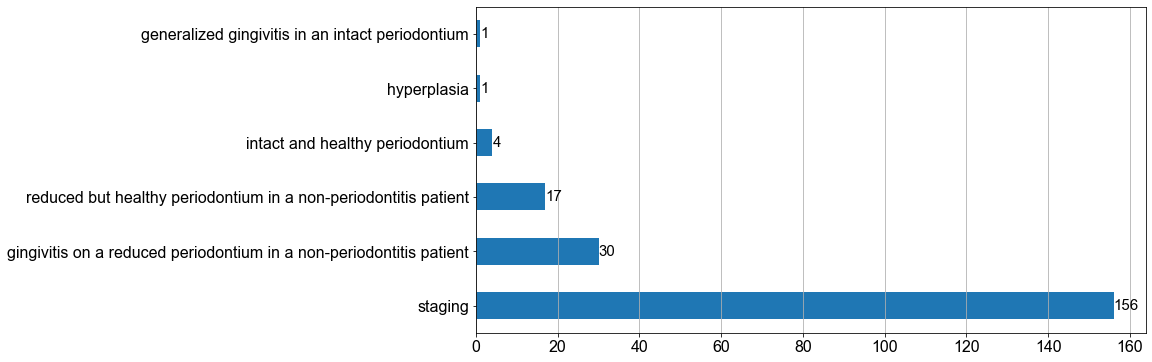

In [39]:
_special_staging_cases = special_staging_cases.copy()
_special_staging_cases["classification"] = "staging"
ax = (
    pd.concat([_special_staging_cases, _non_periodontitis_patient])["classification"]
    # special_cases["classification"]
    .value_counts().plot.barh()
)
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.set_ylabel("")
ax.grid(axis="x")

In [40]:
980 - 156 - 53

771

## Save to disk

In [41]:
print(data.shape)
print(special_staging_cases.shape)
print(_non_periodontitis_patient.shape)

(771, 748)
(156, 748)
(53, 749)


In [42]:
out_data = pd.concat([data, special_staging_cases])
out_data.shape

(927, 748)

In [43]:
fn = "dmsV_periodontitis_cases.parquet"
fp = DATA.joinpath("processed", fn)
out_data.to_parquet(fp)
assert fp.exists(), fp

In [44]:
fn = "dmsV_non_periodontitis_patient.parquet"
fp = DATA.joinpath("processed", fn)
_non_periodontitis_patient.to_parquet(fp)
assert fp.exists(), fp

### Save dict

In [45]:
out = (staged_patients, non_periodontitis_patient)